<a href="https://colab.research.google.com/github/Sumaira-willis/Activity-2/blob/main/Assignment_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Cell 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import shap
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [20]:
# Cell 2: Load data
df = pd.read_csv("bank-loan.csv")

print("Initial shape:", df.shape)
df.head()


Initial shape: (850, 9)


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [21]:
# Cell 3: Inspect and clean target
print("\nInfo:")
print(df.info())

print("\nMissing counts:")
print(df.isna().sum())

# Drop rows with missing target 'default'
df = df.dropna(subset=['default'])
df['default'] = df['default'].astype(int)

print("\nShape after dropping missing target:", df.shape)



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB
None

Missing counts:
age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     150
dtype: int64

Shape after dropping missing target: (700, 9)


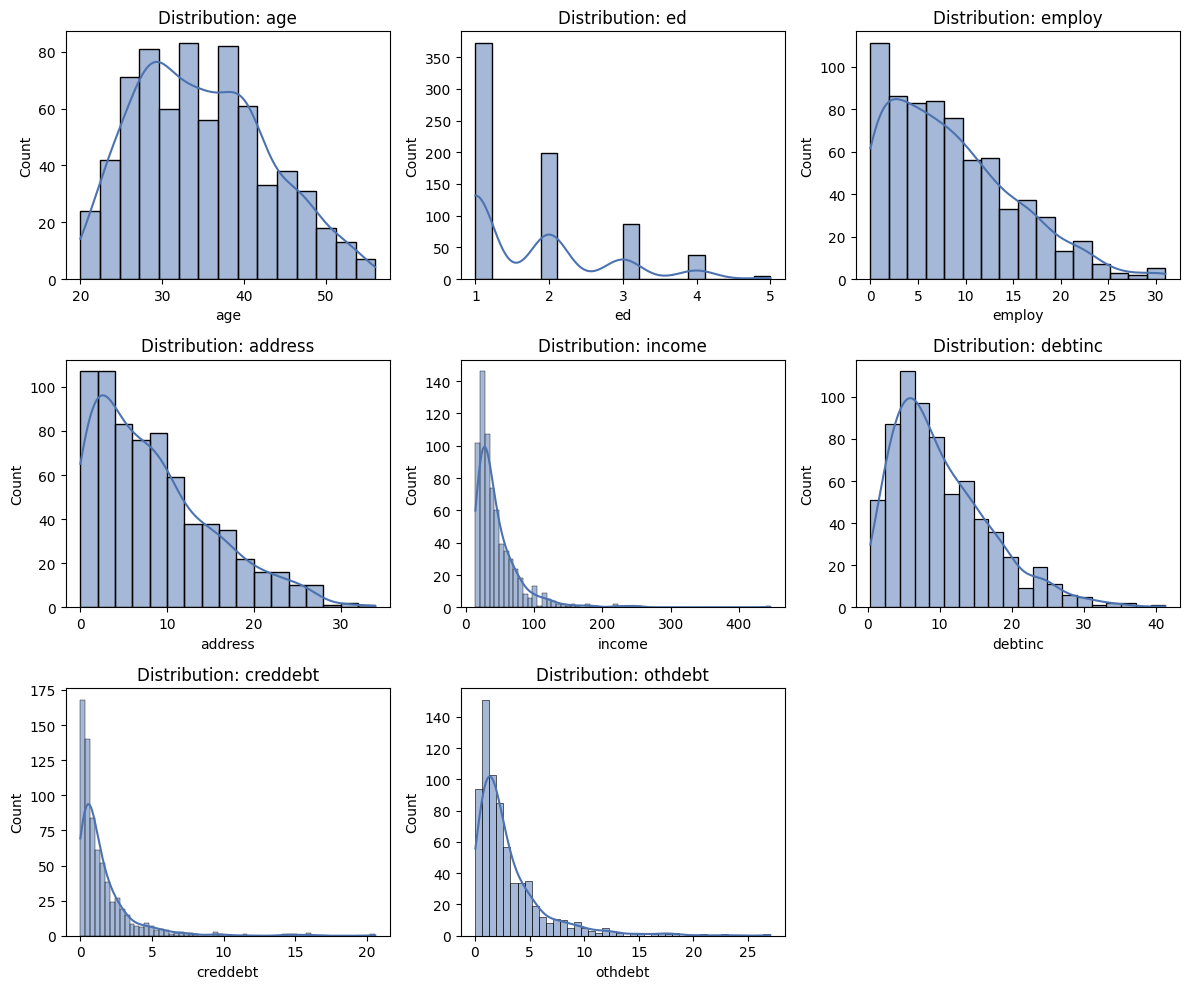

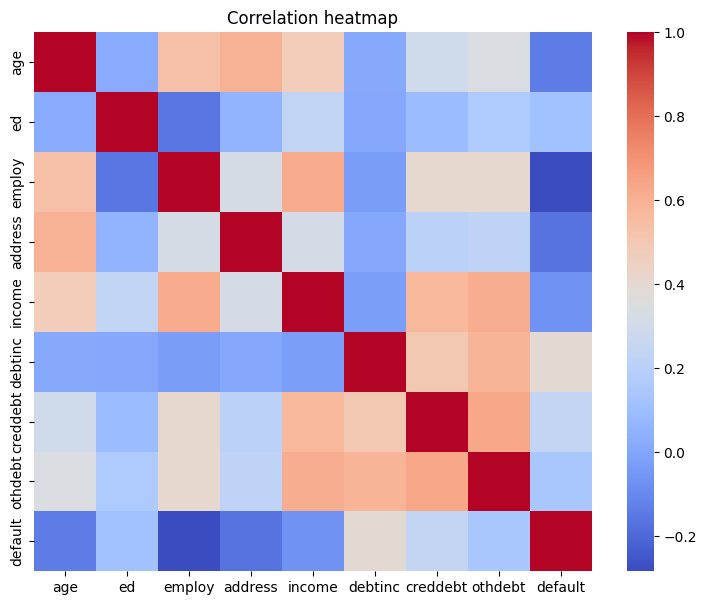

In [22]:
# Cell 4: Quick EDA visuals (optional)
numeric_cols = ['age','ed','employ','address','income','debtinc','creddebt','othdebt']
target_col = 'default'

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color="#4C72B0")
    axes[i].set_title(f"Distribution: {col}")
axes[-1].axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,7))
sns.heatmap(df[numeric_cols + [target_col]].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation heatmap")
plt.show()


In [23]:
# Cell 5: Define X, y and engineer features
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# Feature engineering (add inside X so pipeline can see them)
eps = 1e-6
X['debt_to_income'] = X['debtinc'] / (X['income'] + eps)
X['credit_to_other_debt'] = X['creddebt'] / (X['othdebt'] + eps)

num_features = X.columns.tolist()
print("Number of features (including engineered):", len(num_features))


Number of features (including engineered): 10


In [24]:
# Cell 6: Preprocessor that imputes + scales numerical features
preprocess = ColumnTransformer(
    transformers=[
        ('num_impute_scale', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), num_features)
    ],
    remainder='drop'
)


In [25]:
# Cell 7: Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

# Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Pipeline: preprocess -> RF
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', rf)
])

# Fit
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))


Accuracy: 0.817
Confusion matrix:
 [[115  14]
 [ 18  28]]

Classification report:
               precision    recall  f1-score   support

           0      0.865     0.891     0.878       129
           1      0.667     0.609     0.636        46

    accuracy                          0.817       175
   macro avg      0.766     0.750     0.757       175
weighted avg      0.813     0.817     0.814       175



In [26]:
# Cell 8: Feature importances aligned with transformed names
rf_model = model.named_steps['rf']
preprocess_fitted = model.named_steps['preprocess']

# Feature names after preprocessing
feature_names = preprocess_fitted.get_feature_names_out()

# Importances length must match number of features
importances = rf_model.feature_importances_

# Sanity check to avoid the "All arrays must be the same length" error
assert len(feature_names) == len(importances), (
    f"Length mismatch: names={len(feature_names)} importances={len(importances)}"
)

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}) \
            .sort_values('importance', ascending=False)

print(feat_imp.head(15))


                                  feature  importance
2                num_impute_scale__employ    0.158986
5               num_impute_scale__debtinc    0.150297
8        num_impute_scale__debt_to_income    0.140739
6              num_impute_scale__creddebt    0.109596
9  num_impute_scale__credit_to_other_debt    0.091261
7               num_impute_scale__othdebt    0.090578
0                   num_impute_scale__age    0.081102
3               num_impute_scale__address    0.079471
4                num_impute_scale__income    0.067175
1                    num_impute_scale__ed    0.030796


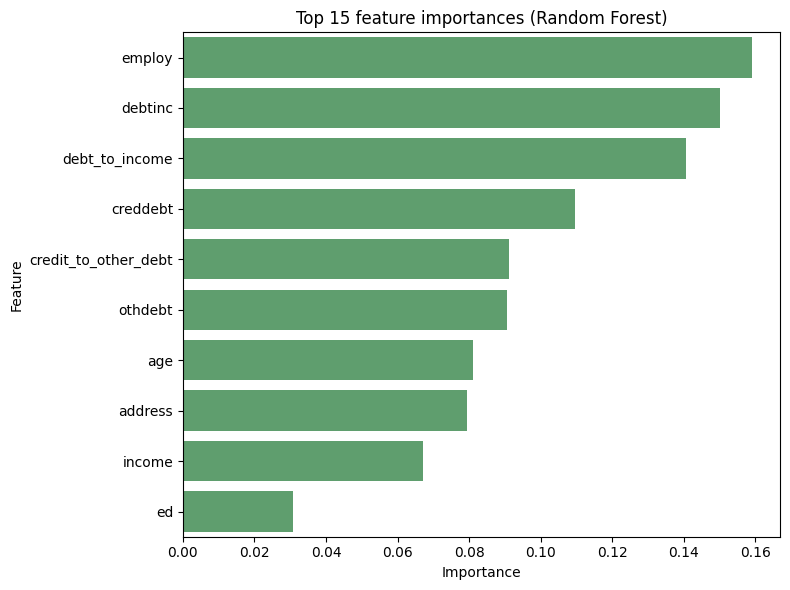

In [27]:
# Cell 9: Plot top feature importances with clean names
clean_names = [name.split("__")[-1] for name in feature_names]
feat_imp_clean = feat_imp.copy()
feat_imp_clean['feature'] = [f.split("__")[-1] for f in feat_imp_clean['feature']]

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=feat_imp_clean.head(15), color="#55A868")
plt.title("Top 15 feature importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [32]:
# Step 1: Transform the full test set with the pipeline
preprocess_fitted = model.named_steps['preprocess']
X_test_proc = preprocess_fitted.transform(X_test)

# Step 2: Get feature names
feat_names_proc = preprocess_fitted.get_feature_names_out()

# Step 3: Wrap into DataFrame
X_test_df = pd.DataFrame(X_test_proc, columns=feat_names_proc)

# Step 4: Use the RF model directly
rf_model = model.named_steps['rf']
explainer = shap.TreeExplainer(rf_model)

# Step 5: Compute SHAP values on the full transformed test set
shap_values = explainer.shap_values(X_test_df)

# Step 6: Confirm alignment
print("SHAP values shape (class 1):", shap_values[1].shape)
print("X_test_df shape:", X_test_df.shape)


SHAP values shape (class 1): (10, 2)
X_test_df shape: (175, 10)


In [34]:
# Safely strip transformer prefixes if present
clean_names = [name.split("__")[-1] for name in X_test_df.columns]
X_test_df.columns = clean_names


In [40]:
# Define age group buckets
def make_age_group(age):
    if age < 25: return "<25"
    elif age < 35: return "25-34"
    elif age < 45: return "35-44"
    elif age < 55: return "45-54"
    else: return "55+"

# Apply age grouping to test set
age_groups = X_test['age'].apply(make_age_group)

# Get predicted probabilities and binary predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_bin = (y_pred_proba >= 0.5).astype(int)

# Initialize slice metrics
slice_metrics = []

# Loop through each age group
for grp in sorted(age_groups.unique()):
    idxs = age_groups[age_groups == grp].index
    y_true_g = y_test.loc[idxs]
    y_pred_g = pd.Series(y_pred_bin, index=X_test.index).loc[idxs]

    # Get classification report safely
    report_g = classification_report(y_true_g, y_pred_g, output_dict=True, zero_division=0)

    # Append metrics with safe fallback for missing class '1'
    slice_metrics.append({
        'age_group': grp,
        'support': int(report_g['macro avg']['support']),
        'accuracy': accuracy_score(y_true_g, y_pred_g),
        'precision_default': report_g.get('1', {}).get('precision', 0),
        'recall_default': report_g.get('1', {}).get('recall', 0),
        'f1_default': report_g.get('1', {}).get('f1-score', 0)
    })

# Display slice metrics
pd.DataFrame(slice_metrics).sort_values('age_group')


,age_group,support,accuracy,precision_default,recall_default,f1_default
0,25-34,83,0.819277,0.772727,0.629630,0.693878
1,35-44,62,0.854839,0.545455,0.600000,0.571429
2,45-54,20,0.800000,0.750000,0.500000,0.600000
3,55+,1,1.000000,0.000000,0.000000,0.000000
4,<25,9,0.555556,0.400000,0.666667,0.500000


In [41]:
# Transform test set using fitted preprocessor
X_test_proc = model.named_steps['preprocess'].transform(X_test)
feat_names_proc = model.named_steps['preprocess'].get_feature_names_out()
X_test_df = pd.DataFrame(X_test_proc, columns=feat_names_proc)

# Clean feature names for readability
clean_names = [name.split("__")[-1] for name in feat_names_proc]
X_test_df.columns = clean_names

# Initialize SHAP explainer
rf_model = model.named_steps['rf']
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for class 1 (default)
shap_values = explainer.shap_values(X_test_df)


In [42]:
shap.summary_plot(shap_values[1], X_test_df, feature_names=clean_names, plot_type="bar")


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [43]:
# Define age group buckets
def make_age_group(age):
    if age < 25: return "<25"
    elif age < 35: return "25-34"
    elif age < 45: return "35-44"
    elif age < 55: return "45-54"
    else: return "55+"

# Apply age grouping
age_groups = X_test['age'].apply(make_age_group)

# Get model predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_bin = (y_pred_proba >= 0.5).astype(int)

# Collect metrics per age group
slice_metrics = []
for grp in sorted(age_groups.unique()):
    idxs = age_groups[age_groups == grp].index
    y_true_g = y_test.loc[idxs]
    y_pred_g = pd.Series(y_pred_bin, index=X_test.index).loc[idxs]
    report_g = classification_report(y_true_g, y_pred_g, output_dict=True, zero_division=0)

    slice_metrics.append({
        'age_group': grp,
        'support': int(report_g['macro avg']['support']),
        'accuracy': accuracy_score(y_true_g, y_pred_g),
        'precision_default': report_g.get('1', {}).get('precision', 0),
        'recall_default': report_g.get('1', {}).get('recall', 0),
        'f1_default': report_g.get('1', {}).get('f1-score', 0)
    })

# Display results
fairness_df = pd.DataFrame(slice_metrics).sort_values('age_group')
print(fairness_df)


  age_group  support  accuracy  precision_default  recall_default  f1_default
0     25-34       83  0.819277           0.772727        0.629630    0.693878
1     35-44       62  0.854839           0.545455        0.600000    0.571429
2     45-54       20  0.800000           0.750000        0.500000    0.600000
3       55+        1  1.000000           0.000000        0.000000    0.000000
4       <25        9  0.555556           0.400000        0.666667    0.500000
